In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import torch
from tqdm.notebook import tqdm

#from transformers import BertTokenizer
from transformers import XLMRobertaTokenizer
from torch.utils.data import TensorDataset

#from transformers import BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np

from datasets import load_dataset

dataset = load_dataset('xnli', 'en')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [ ]:
dataset['train']

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [ ]:
train = [f"[CLS] {p} [SEP] {h} [SEP]" for p, h in zip(dataset['train']['premise'][:8000], dataset['train']['hypothesis'][:8000])]
validation = [f"[CLS] {p} [SEP] {h} [SEP]" for p, h in zip(dataset['validation']['premise'], dataset['validation']['hypothesis'])]

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    validation,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset['train']['label'][:8000])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset['validation']['label'])

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', #"bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0271091010048985
Validation loss: 0.8266755602206571
F1: 0.6519455301302971


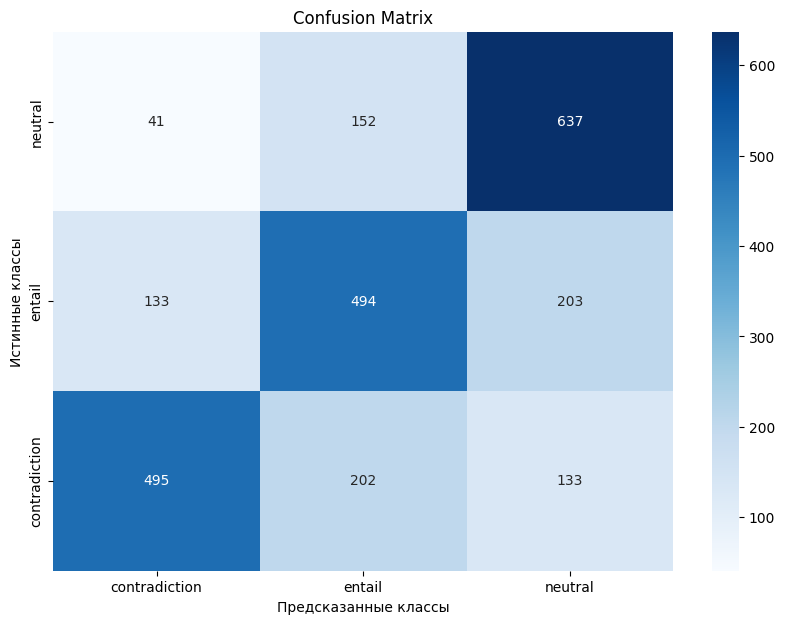

Class: contradiction
Accuracy: 495/830 (True Positives / Total Actual Positives)
Precision: 0.74
Recall: 0.60
F1 Score: 0.66

Class: entail
Accuracy: 494/830 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.60
F1 Score: 0.59

Class: neutral
Accuracy: 637/830 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.77
F1 Score: 0.71



Epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7401170866563916
Validation loss: 0.6849747757954769
F1: 0.7220755996206814


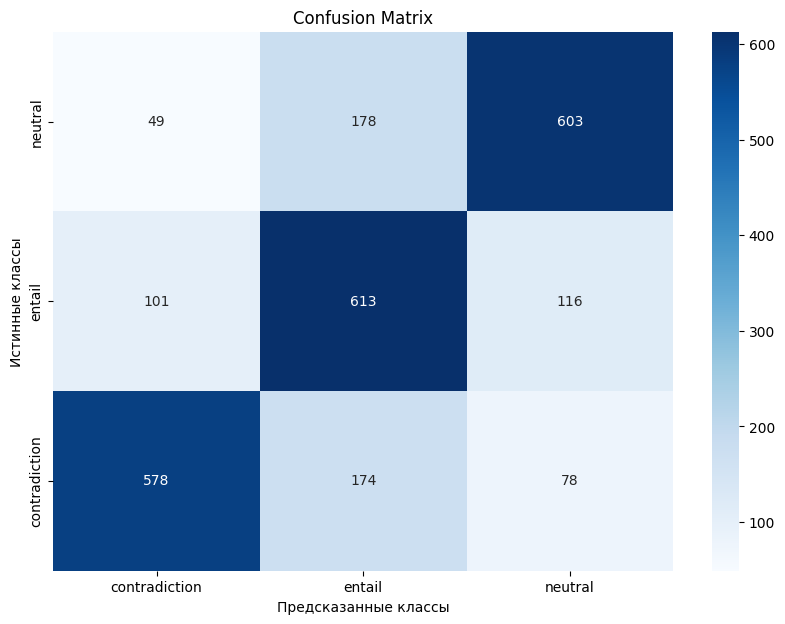

Class: contradiction
Accuracy: 578/830 (True Positives / Total Actual Positives)
Precision: 0.79
Recall: 0.70
F1 Score: 0.74

Class: entail
Accuracy: 613/830 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.74
F1 Score: 0.68

Class: neutral
Accuracy: 603/830 (True Positives / Total Actual Positives)
Precision: 0.76
Recall: 0.73
F1 Score: 0.74



Epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.570362433725968
Validation loss: 0.7072527859374941
F1: 0.7282648019356097


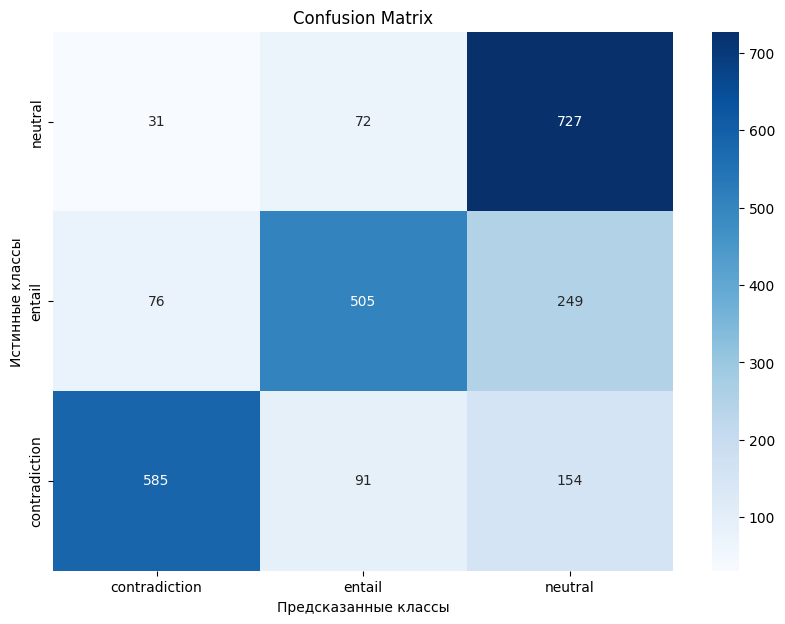

Class: contradiction
Accuracy: 585/830 (True Positives / Total Actual Positives)
Precision: 0.85
Recall: 0.70
F1 Score: 0.77

Class: entail
Accuracy: 505/830 (True Positives / Total Actual Positives)
Precision: 0.76
Recall: 0.61
F1 Score: 0.67

Class: neutral
Accuracy: 727/830 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.88
F1 Score: 0.74



Epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4442914928216487
Validation loss: 0.714114766665192
F1: 0.7510293222532027


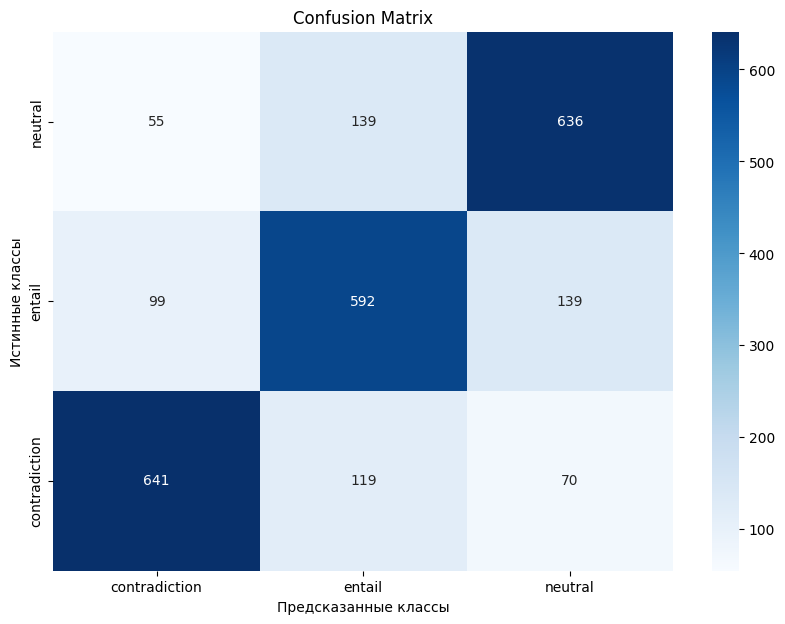

Class: contradiction
Accuracy: 641/830 (True Positives / Total Actual Positives)
Precision: 0.81
Recall: 0.77
F1 Score: 0.79

Class: entail
Accuracy: 592/830 (True Positives / Total Actual Positives)
Precision: 0.70
Recall: 0.71
F1 Score: 0.70

Class: neutral
Accuracy: 636/830 (True Positives / Total Actual Positives)
Precision: 0.75
Recall: 0.77
F1 Score: 0.76



Epoch 5:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3539016630698461
Validation loss: 1.0913465888441416
F1: 0.7419847815084326


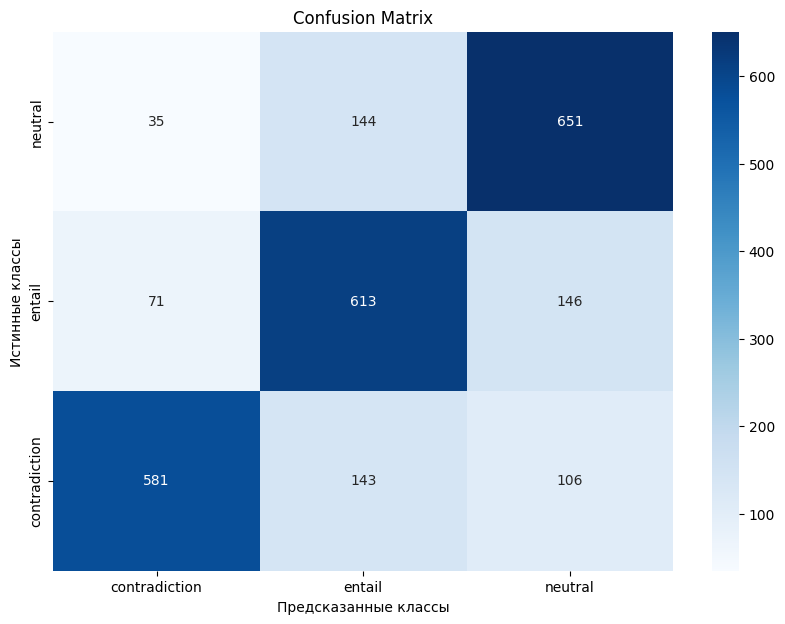

Class: contradiction
Accuracy: 581/830 (True Positives / Total Actual Positives)
Precision: 0.85
Recall: 0.70
F1 Score: 0.77

Class: entail
Accuracy: 613/830 (True Positives / Total Actual Positives)
Precision: 0.68
Recall: 0.74
F1 Score: 0.71

Class: neutral
Accuracy: 651/830 (True Positives / Total Actual Positives)
Precision: 0.72
Recall: 0.78
F1 Score: 0.75



Epoch 6:   0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

min_loss = 10

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1: {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2} #https://github.com/yg211/bert_nli/blob/master/test_trained_model.py | str 30
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

    if val_f1 < min_loss:
        min_loss = val_loss
        model.save_pretrained(f"/content/XNLI_en_roberta")

In [ ]:
model.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/XNLI_en_roberta")